In [1]:
# Loading relevant libraries
import numpy as np
import os
import scipy
from scipy import signal, stats
from matplotlib  import pyplot as plt
from scipy.signal import butter, lfilter
import sys
from importlib import import_module

##### Loading preprocessed data

In [2]:
# root directory for extracted data
root_data = r"C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\SN_pilot_data\derivatives\pilot"

#loading: COVERT data
os.chdir(root_data)
tmp_covert = np.load("pilot_cvep_covert_mgold_61_6521_40T.npz")
X = tmp_covert["X"]
y = tmp_covert["y"]
V = tmp_covert["V"].T
fs = tmp_covert["fs"]
fr = 60

# For our experiment, we used only two classes. Hence, the flashing sequence matrix is limited to the first two codes in V.
V_needed = V[0:2,:]
V = V_needed

print("X", X.shape, "(trials x channels x samples)")  # EEG
print("y", y.shape, "(trials)")  # labels
print("V", V.shape, "(classes, samples)")  # codes
print("fs", fs, "Hz")  # sampling frequency
print("fr", fr, "Hz")  # presentation rate
print("trial duration was", X.shape[2]/fs,"s")


# Extract data dimensions
n_trials, n_channels, n_samples = X.shape
n_classes = V.shape[0]

# Read cap file
path = r"C:\Users\s1081686\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyntbci\capfiles" 
capfile = os.path.join(path, "biosemi32.loc")
with open(capfile, "r") as fid:
    channels = []
    for line in fid.readlines():
        channels.append(line.split("\t")[-1].strip())
print("Channels:", ", ".join(channels))

X (40, 32, 2520) (trials x channels x samples)
y (40,) (trials)
V (2, 504) (classes, samples)
fs 240 Hz
fr 60 Hz
trial duration was 10.5 s
Channels: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, O1, Oz, O2, PO4, P4, P8, CP6, CP2, C4, T8, FC6, FC2, F4, F8, AF4, Fp2, Fz, Cz


##### Splitting data into two classes

In [3]:

# Data and codes for 'N'key/class appearing on the right
ind_0 = (y==0)
X_0 = X[ind_0,:,:] 
V_0 = V[0,:].reshape(1,504)

# # Data and codes for 'Y' key/class appearing on the left
ind_1 = (y==1)
X_1 = X[ind_1,:,:] 
V_1 = V[1,:].reshape(1,504)

print("Shape of data after separation",X_0.shape,"(trials x channels x samples)") 

# labels
y_ind=np.zeros((20,1))

# Using the spatial filters from rCCA_Covert
w_0 = np.load(r'C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\SN_analysis\sp_filters\w_0.npy')
w_1 = np.load(r'C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\SN_analysis\sp_filters\w_1.npy')
print('shape of spatial filter:',w_0.shape)

# Filtering Data and reshaping it into trials x samples format
X_0_filt = np.dot(w_0.T,X_0.reshape(X_0.shape[1],X_0.shape[0]*X_0.shape[2])).reshape(X_0.shape[0],X_0.shape[2])
X_1_filt = np.dot(w_1.T,X_1.reshape(X_1.shape[1],X_1.shape[0]*X_1.shape[2])).reshape(X_1.shape[0],X_1.shape[2])

print("shape of X after spatial filtering", X_0_filt.shape,'(trials x samples)') 

Shape of data after separation (20, 32, 2520) (trials x channels x samples)
shape of spatial filter: (32, 1)
shape of X after spatial filtering (20, 2520) (trials x samples)


##### Defining relevant functions

In [4]:
def BPF_Sig(X,low,high,fs,order=4):
    """
    Args:
        X (array): 
            EEG Data for selected channels with shape trials x samples 
        low (float): 
            Lower limit of the passband
        high (float):  
            Upper limit of the passband
        fs (float): 
            Sampling frequency of the EEG data
        order (int): 
            Order of the butterworth filter
    Returns:
        x_filt (array): Filtered EEG data
    """
    
    nyq = 0.5*fs
    b,a = butter(order,[low / nyq, high / nyq],btype="band")
    
    X_filt = lfilter(b,a,X)
    
    return X_filt

def bandpower_PSD(X,fs,plot):    
    """
      Args:
            X (array): 
                EEG Data for selected channels with shape trials x samples 

            fs (float): 
                Sampling frequency of the EEG data
            order (int): 
                Order of the butterworth filter
        Returns:
            Pxx (in dB), f (array): 
                Power across the frequency components present in the signal, if shape of data is n x m, output vector is n x fn where fn is the array with freq components 
    """    
    
    f, Pxx = signal.welch(X, fs=fs, scaling ='density', window = 'hamming')
    
    if plot == True:
        plt.plot(f, 10*np.log10(Pxx))
        plt.xlim([0, 100])
        plt.xlabel('frequency [Hz]')
        plt.ylabel('PSD dB')
        
    
    return 10*np.log10(Pxx), f

def plot_timefreq(X,fs,label,chan,width=6):
    """
      Args:
            X (array): 
                EEG Data for selected channels with shape trials x samples 

            fs (float): 
                Sampling frequency of the EEG data
            width (int): 
                Width of the morlet wavelet (default = 6)
            label (str):
                Class of the EEG Data fed as input (either "0" or "1")
            Chan (str):
                Name of the channel ("Po3" or "Po4")
            
        Returns:
            Pxx (in dB), f (array): 
                Power across the frequency components present in the signal, if shape of data is n x m, output vector is n x fn where fn is the array with freq components 
    """ 
    
    if label=="0":
        side = "right"
    else:
        side = "left"
    
    t = np.linspace(0,X.shape[1]/fs,X.shape[1]) # x-axis
    fs = fs
    width_morlet = width
    sig = X
    freq = np.linspace(1,fs/2,X.shape[1]) # y-axis
    widths = width_morlet*fs/ (2*freq*np.pi)
    
    cwtm_all =np.array([signal.cwt(sig[ind,:], scipy.signal.morlet2, widths, w = width_morlet) for ind in range(X.shape[0])])
    print("shape of all wavelet transforms", cwtm_all.shape)
    
    # computing power for all trials
    cwtm_all_pow = 10*np.log10(np.abs(cwtm_all)**2)
    
    print("shape of power of all the wavelet transforms", cwtm_all_pow.shape)
    
    cwtm_mean_pow = np.mean(cwtm_all_pow,axis=0)
    
    # plt.pcolormesh(t, freq, 10*np.log10(np.abs(cwtm_mean)**2),cmap = 'hot')
    plt.pcolormesh(t, freq, cwtm_mean_pow,cmap = 'hot')
    plt.colorbar(label= 'dB (avg)')
    plt.xlabel('Time(s)')
    plt.ylabel('Frequency')
    plt.title(f'{chan} class {label}/{side} stim')
    
def plot_hilbert(X,fs,label,option):
    """
      Args:
            X (array): 
                EEG Data for selected channels with shape trials x samples 

            fs (float): 
                Sampling frequency of the EEG data
            label (str):
                Class of the EEG Data fed as input (either "0" or "1")
            Option (str):
                Y axis units are either in "dB" or in "amp^2"
            
        Returns:
            Bandpower vs Time plot for given data
    """ 
    
    if label=="0":
        side = "right"
    else:
        side = "left"
        
    X_hilb = scipy.signal.hilbert(X)
    
    if option == 'dB':
        power_all = 10 * np.log10(np.abs(X_hilb)** 2) # y-axis
        ylabel = "Power (dB)"
    else:
        power_all = np.abs(X_hilb)** 2 # y axis
        ylabel = "Power (Amp^2)"
        
    time = np.linspace(0,X.shape[1]/fs,X.shape[1]) # x-axis
    power_mean = np.mean(power_all,axis=0)
  
    plt.plot(time,power_mean)
    plt.xlabel('Time(s)')
    plt.ylabel(ylabel)
    plt.title(f'Po3 vs Po4 Power vs time class {label}/{side} stim')


##### Part A: Looking at power of the spatially filtered data

In [5]:
# 'PSD Plots'
# # filtering in the 8-12 Hz
# X_0_bpf = BPF_Sig(X_0_filt, low = 8, high = 12, fs = fs)
# X_1_bpf = BPF_Sig(X_1_filt, low = 8, high = 12, fs = fs)

# # Checking the PSD 
# pow_X0, _ = bandpower_PSD(X_0_filt, fs=fs, plot = False)
# pow_X1, _= bandpower_PSD(X_1_filt, fs=fs, plot = False)

# pow_X0_bpf, _ = bandpower_PSD(X_0_bpf, fs=fs, plot = False)
# pow_X1_bpf, _= bandpower_PSD(X_1_bpf, fs=fs, plot = False)

# plt.figure(figsize= (16,4))
# plt.subplot(121)
# plt.plot(np.mean(pow_X0_bpf,axis = 0))
# plt.plot(np.mean(pow_X1_bpf,axis = 0))
# plt.ylabel('dB')
# plt.xlabel('freq')
# plt.title('Avg PSD for spatially filtered data:8-12 Hz')
# plt.legend(['class 0','class 1'])

# plt.subplot(122)
# plt.plot(np.mean(pow_X0,axis = 0))
# plt.plot(np.mean(pow_X1,axis = 0))
# plt.ylabel('dB')
# plt.xlabel('freq')
# plt.title('Avg PSD for spatially filtered data')
# plt.legend(['class 0','class 1'])

# 'Time Frequency Plots: broadband'
# plt.figure(figsize= (16,4))
# plt.subplot(121)
# plot_timefreq(X_0_filt,fs= fs,label="0",chan = '-')
# plt.subplot(122)
# plot_timefreq(X_1_filt,fs= fs,label="1",chan = '-')
# plt.show()

# 'Hilbert plots: Narrow band'
# # choose dB or Amp^2
# option  = "dB"   
# # plot bandpower
# plt.figure(figsize= (16,4))
# plot_hilbert(X_0_bpf,fs = fs, label = "0",option=option)
# plot_hilbert(X_1_bpf,fs = fs, label = "1", option=option)
# plt.title('Class 0 vs Class 1 variation in power')
# plt.legend(['class 0','class 1'])

##### Part B: Extracting relevant channels for alpha activity (Po3,Po4 and Cz as reference)

##### _Note: We start with the preprocessed data with no spatial filtering in this case_ 

In [6]:
# indices
ind_po3 = channels.index("PO3")
ind_po4 = channels.index('PO4')
ind_ref = channels.index('Cz')

# matching data for indices

#reference
ref_0 = X_0[:,ind_ref,:]
ref_1 = X_1[:,ind_ref,:]

# class 0
po3_class0 = X_0[:,ind_po3,:]
po4_class0 = X_0[:,ind_po4,:]

# class 1
po3_class1 = X_1[:,ind_po3,:]
po4_class1 = X_1[:,ind_po4,:]

# filtered versions of all channels
low = 8
high = 12

ref_0_filt = BPF_Sig(ref_0,low, high, fs= fs, order=4)
ref_1_filt = BPF_Sig(ref_1,low, high, fs= fs, order=4)

po3_class0_filt = BPF_Sig(po3_class0, low, high, fs= fs, order=4)
po4_class0_filt = BPF_Sig(po4_class0, low, high, fs= fs, order=4)

po3_class1_filt = BPF_Sig(po3_class1, low, high, fs= fs, order=4)
po4_class1_filt = BPF_Sig(po4_class1, low, high, fs= fs, order=4)
print("dimensions of EEG data after extraction and/or filtering:", po3_class0_filt.shape,"(trials x samples)")


dimensions of EEG data after extraction and/or filtering: (20, 2520) (trials x samples)


##### How does power in the **alpha band** Po3/Po4 vary _across trials_? What is the relationship between the two channels?

corr between po3,po4 class 0 0.9901676175183387
corr between po3,po4 class 1 0.9880114399584332


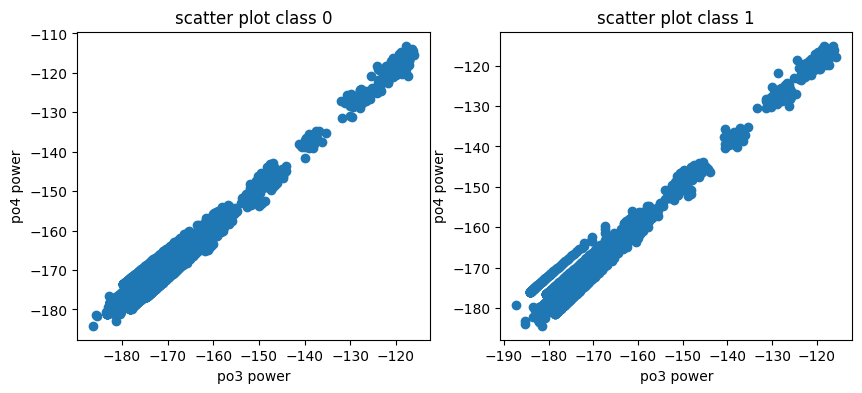

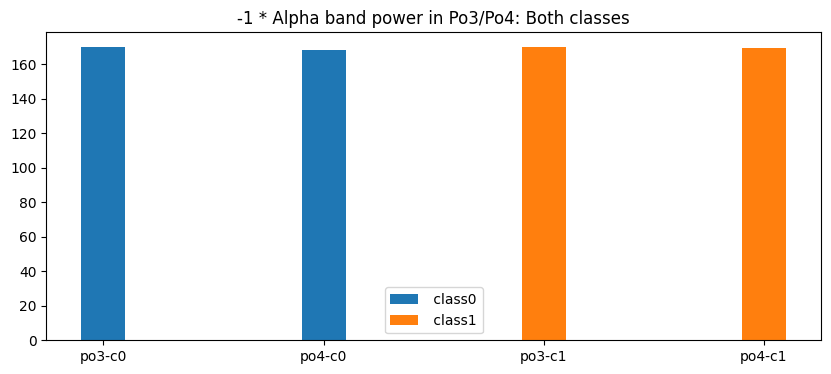

In [7]:
# ref power
pow_ref_0,_=  bandpower_PSD(ref_0_filt,fs,plot = False)
pow_ref_1,_ =  bandpower_PSD(ref_1_filt,fs,plot = False)


# class 0 power
pow_po3_class0,f0 =  bandpower_PSD(po3_class0_filt,fs,plot = False) 
pow_po4_class0,_ =  bandpower_PSD(po4_class0_filt,fs,plot = False) 

# class 1 power
pow_po3_class1,f1 =  bandpower_PSD(po3_class1_filt,fs,plot = False)
pow_po4_class1,_ =  bandpower_PSD(po4_class1_filt,fs,plot = False)

# scatter plot 
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(pow_po3_class0,pow_po4_class0)
plt.xlabel('po3 power')
plt.ylabel('po4 power')
plt.title('scatter plot class 0')

plt.subplot(122)
plt.scatter(pow_po3_class1,pow_po4_class1)
plt.xlabel('po3 power')
plt.ylabel('po4 power')
plt.title('scatter plot class 1')

'# correlation'
r_0,_ = stats.pearsonr(pow_po3_class0.flatten(),pow_po4_class0.flatten())
r_1,_ = stats.pearsonr(pow_po3_class1.flatten(),pow_po4_class1.flatten())

print("corr between po3,po4 class 0",r_0)
print("corr between po3,po4 class 1",r_1)

'bar plots'
plt.figure(figsize=(10,4))
plt.bar(['po3-c0','po4-c0'],[-np.mean(pow_po3_class0, axis=0).mean(),-np.mean(pow_po4_class0, axis=0).mean()], width = 0.2)
plt.bar(['po3-c1','po4-c1'],[-np.mean(pow_po3_class1, axis=0).mean(),-np.mean(pow_po4_class1, axis=0).mean()],width = 0.2)
plt.legend([' class0',' class1'])
plt.title('-1 * Alpha band power in Po3/Po4: Both classes')

plt.show()




# re-referencing option
# pow_po3_class0 = pow_po3_class0 -  pow_ref_0
# pow_po4_class0 = pow_po4_class0 -  pow_ref_0

# pow_po3_class1 = pow_po3_class1 -  pow_ref_1
# pow_po4_class1 = pow_po4_class1 -  pow_ref_1

##### Average PSD plots (filtered and unfiltered signal)

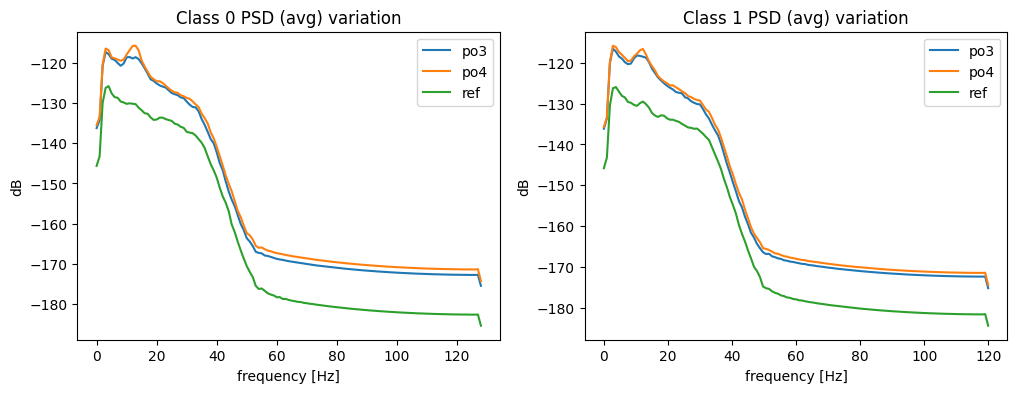

In [8]:
# unfiltered signal plots

# ref power
pow_ref_0_unf,_=  bandpower_PSD(ref_0,fs,plot = False)
pow_ref_1_unf,_ =  bandpower_PSD(ref_1,fs,plot = False)


# class 0 power
pow_po3_class0_unf,f0_unf =  bandpower_PSD(po3_class0,fs,plot = False) 
pow_po4_class0_unf,_ =  bandpower_PSD(po4_class0,fs,plot = False) 

# class 1 power
pow_po3_class1_unf,f1_unf =  bandpower_PSD(po3_class1,fs,plot = False)
pow_po4_class1_unf,_ =  bandpower_PSD(po4_class1,fs,plot = False)

plt.figure(figsize = (12,4))
plt.subplot(121)
plt.plot(np.mean(pow_po3_class0_unf,axis = 0)) # avg
plt.plot(np.mean(pow_po4_class0_unf,axis = 0))
plt.plot(np.mean(pow_ref_0_unf,axis = 0))
plt.xlabel('frequency [Hz]')
plt.ylabel('dB')
plt.title('Class 0 PSD (avg) variation')
plt.legend(['po3','po4','ref'])

plt.subplot(122)
plt.plot(f1_unf,np.mean(pow_po3_class1_unf,axis = 0))
plt.plot(f1_unf,np.mean(pow_po4_class1_unf,axis = 0))
plt.plot(f1_unf,np.mean(pow_ref_1_unf,axis = 0))
plt.xlabel('frequency [Hz]')
plt.ylabel('dB')
plt.title('Class 1 PSD (avg) variation')
plt.legend(['po3','po4','ref'])


##### Time- Frequency Spectrum (broad-band)

shape of all wavelet transforms (20, 2520, 2520)
shape of power of all the wavelet transforms (20, 2520, 2520)
shape of all wavelet transforms (20, 2520, 2520)
shape of power of all the wavelet transforms (20, 2520, 2520)


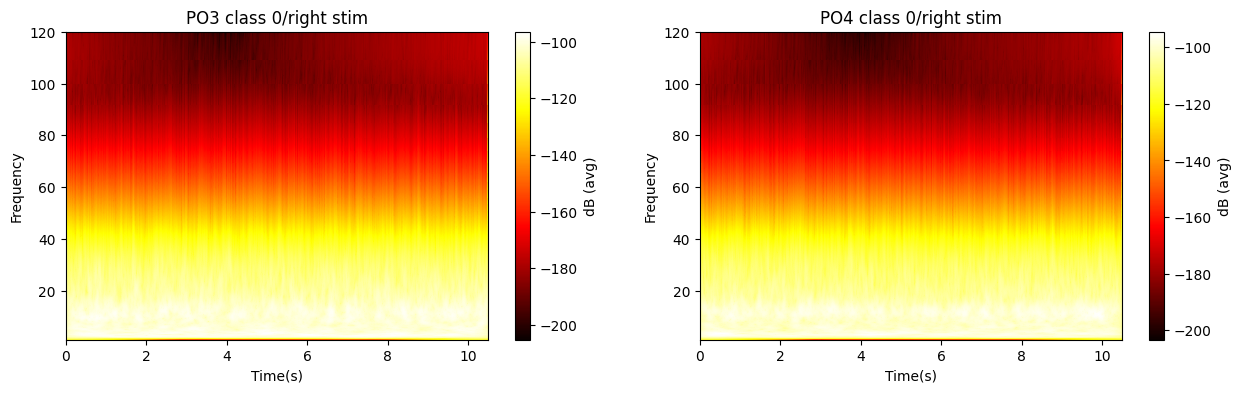

shape of all wavelet transforms (20, 2520, 2520)
shape of power of all the wavelet transforms (20, 2520, 2520)
shape of all wavelet transforms (20, 2520, 2520)
shape of power of all the wavelet transforms (20, 2520, 2520)


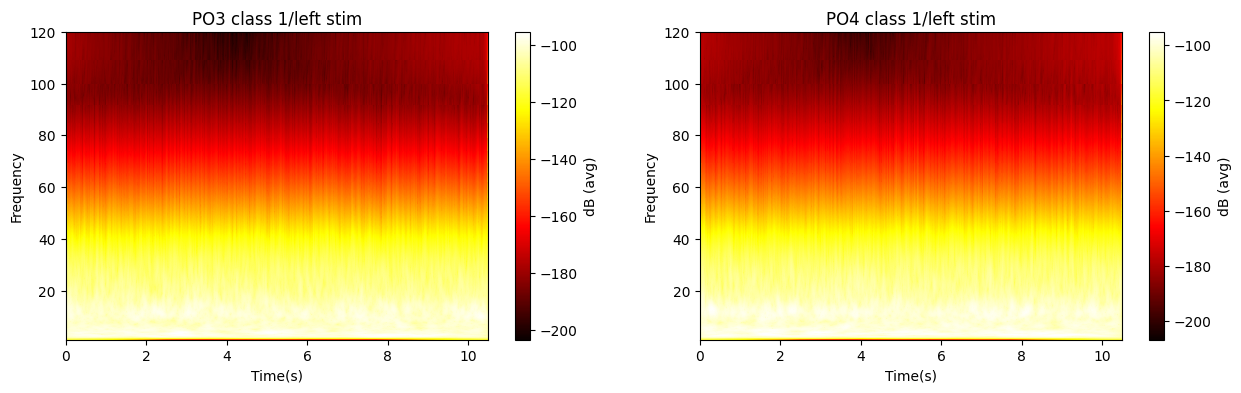

In [9]:
plt.figure(figsize=(15,4))
plt.subplot(121)
plot_timefreq(po3_class0,fs= fs,label="0",chan = 'PO3')
plt.subplot(122)
plot_timefreq(po4_class0,fs= fs,label="0",chan = 'PO4')
plt.show()

plt.figure(figsize=(15,4))
plt.subplot(121)
plot_timefreq(po3_class1,fs= fs,label="1",chan = 'PO3')
plt.subplot(122)
plot_timefreq(po4_class1,fs= fs,label="1",chan = 'PO4')
plt.show()


##### Hilbert Transform and band power across time (narrow band)

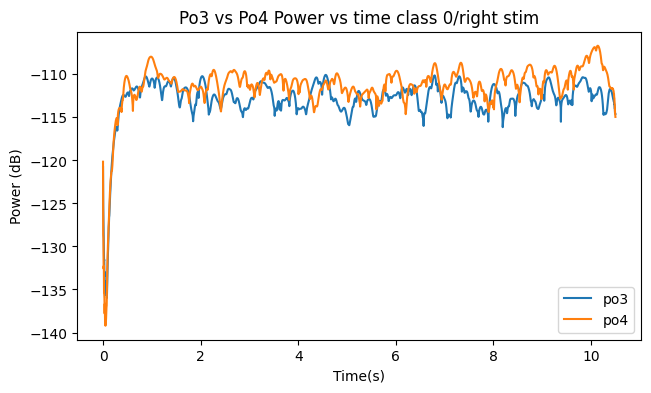

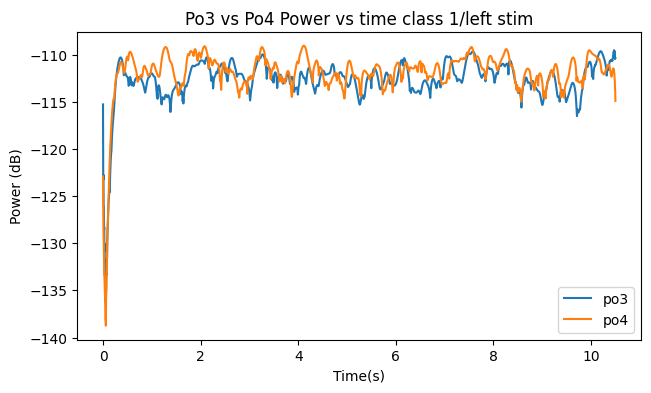

In [10]:
# choose dB or Amp^2
option  = "dB"   
# plot bandpower
plt.figure(figsize= (16,4))
plt.subplot(121)
plot_hilbert(po3_class0_filt,fs = fs, label = "0",option=option)
plot_hilbert(po4_class0_filt,fs = fs, label = "0", option=option)
plt.legend(['po3','po4'])

plt.figure(figsize= (16,4))
plt.subplot(121)
plot_hilbert(po3_class1_filt,fs = fs, label = "1",option=option)
plot_hilbert(po4_class1_filt,fs = fs, label = "1", option=option)
plt.legend(['po3','po4'])

##### Averaging: Comparing two approaches using synthetic data

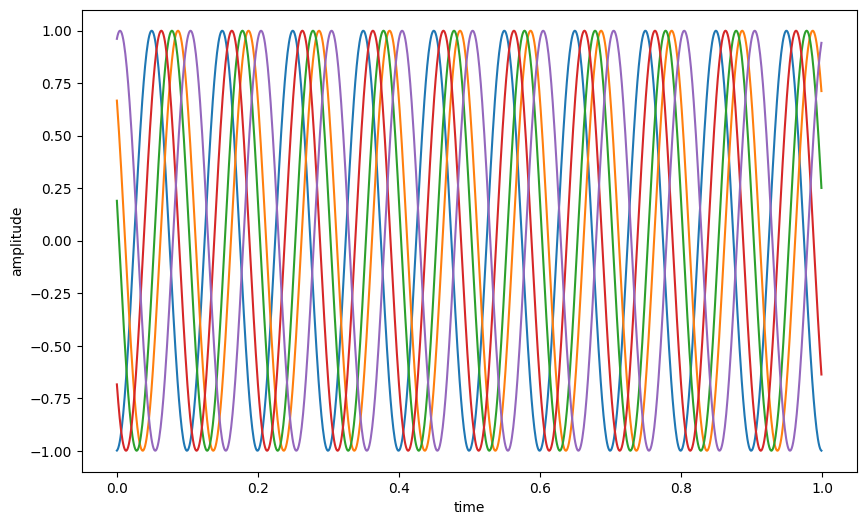

In [11]:
# Parameters
n_sines = 20       # Number of sine waves
n_time_points = 1000  # Number of time points
frequency = 10.0     # Frequency of the sine waves in Hz
fsamp = 100

# Time vector
t = np.linspace(0, 1, n_time_points, endpoint=False)

# Create a matrix to store sine waves
sine_matrix = np.zeros((n_sines, n_time_points))

# Populate the matrix with sine waves of different phases
for i in range(n_sines):
    phase = 2 * np.pi * np.random.rand()  # Random phase between 0 and 2*pi
    sine_wave = np.sin(2 * np.pi * frequency * t + phase)
    sine_matrix[i, :] = sine_wave

# Plot the first 5 sine waves
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(t, sine_matrix[i, :], label=f'Sine Wave {i + 1}')
    plt.xlabel('time')
    plt.ylabel('amplitude')

shape of all wavelet transforms (20, 1000, 1000)
shape of power of all the wavelet transforms (1000, 1000)


Text(0.5, 1.0, 'avging the power')

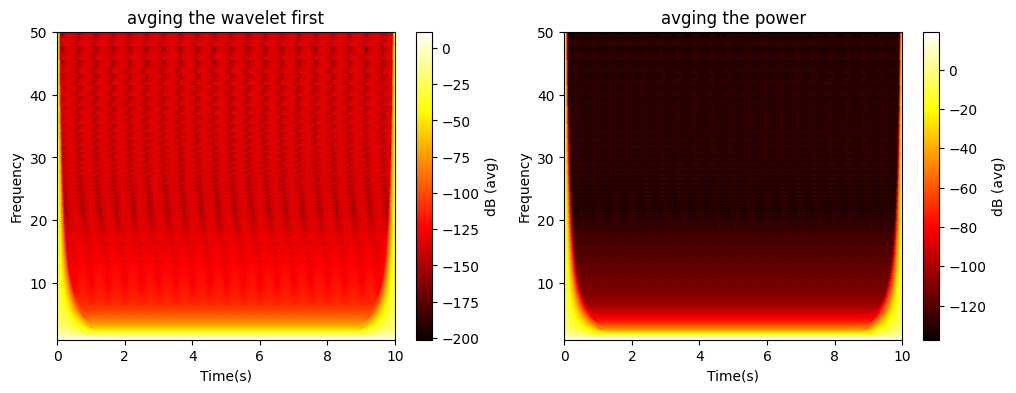

In [12]:
# Approach 1: averaging the wavelet and then calculating the time-freq plot
sig = sine_matrix
fs = 100
t = np.linspace(0,sig.shape[1]/fs,sig.shape[1]) # x-axis
width_morlet = 6
freq = np.linspace(1,fs/2,sig.shape[1]) # y-axis
widths = width_morlet*fs/ (2*freq*np.pi)

cwtm_all =np.array([signal.cwt(sig[ind,:], scipy.signal.morlet2, widths, w = width_morlet) for ind in range(sig.shape[0])])
print("shape of all wavelet transforms", cwtm_all.shape)

cwtm_all_mean = np.mean(cwtm_all,axis =0)

# computing power for all trials
cwtm_all_pow = 10*np.log10(np.abs(cwtm_all_mean)**2)


# second approach: (averaging power and not the wavelet)
cwtm_pow2 = 10*np.log10(np.abs(cwtm_all)**2)
cwtm_pow2_mean = np.mean(cwtm_pow2,axis=0)


print("shape of power of all the wavelet transforms", cwtm_all_pow.shape)

# plotting the time-freq 
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.pcolormesh(t, freq, cwtm_all_pow,cmap = 'hot')
plt.colorbar(label= 'dB (avg)')
plt.xlabel('Time(s)')
plt.ylabel('Frequency')
plt.title('avging the wavelet first')

plt.subplot(122)
plt.pcolormesh(t, freq, cwtm_pow2_mean,cmap = 'hot')
plt.colorbar(label= 'dB (avg)')
plt.xlabel('Time(s)')
plt.ylabel('Frequency')
plt.title('avging the power')